In [1]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Import your dataset and transforms
from dataset_creater import *
from torchsummary import summary
from torchaudio import transforms as T

In [2]:
# Set the path to your dataset
data_folder = "./data"
transform = T.MelSpectrogram(sample_rate=44100, n_mels=64)

# Create an instance of your dataset
dataset = AudioDataset(data_folder, transform=transform)

# Define the sizes of your splits
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
# Move the training and validation data loaders to the selected device
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, shuffle=False)
test_loader = DataLoader(test_set, shuffle=False)


c:\Users\Sine\anaconda3\envs\pytorch\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [3]:
for batch in test_loader:
    padded_waveforms, labels = batch
    print("Padded waveforms shape:", padded_waveforms.shape)
    input_shape = padded_waveforms.shape[1:]
    break
print(input_shape)

Padded waveforms shape: torch.Size([1, 1, 64, 508])
torch.Size([1, 64, 508])


In [4]:
class MelChordClassifier(nn.Module):
    def __init__(self):
        super(MelChordClassifier, self).__init__()
        # Define a CNN with input shape is (batch_size, 1, 128, 199) and output shape is (batch_size, 1)
        # it should reduce the dimensionality very quickly because the dataset is small (<1000)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(4,8), stride=1, padding=0) 
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,8), stride=(2,8)) 

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1)) # shape (batch_size, 128, 1, 1)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 1) # no activation function because we use BCEWithLogitsLoss

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64)
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.fc1(x)
        # Use BCEWithLogitsLoss instead of BCELoss because it combines a Sigmoid layer and the BCELoss in one single class
        # the output shape should be (batch_size,)
        return x.view(-1)

In [5]:


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move it to the selected device
model = MelChordClassifier().to(device)

# Instantiate loss function and move it to the selected device
criterion = nn.BCEWithLogitsLoss().to(device)

# Instantiate optimizer and move it to the selected device
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00001)

# output summary of model
summary(model, input_shape)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 61, 501]           1,056
       BatchNorm2d-2          [-1, 32, 61, 501]              64
              ReLU-3          [-1, 32, 61, 501]               0
         MaxPool2d-4           [-1, 32, 30, 62]               0
            Conv2d-5           [-1, 64, 26, 58]          51,264
              ReLU-6           [-1, 64, 26, 58]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
       BatchNorm1d-8                   [-1, 64]             128
           Dropout-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
Total params: 52,577
Trainable params: 52,577
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 24.31
Params size (MB): 0.20
Estimated To

100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Training - Epoch 1/30, Loss: 0.7109, Accuracy: 0.5560
Validation - Epoch 1/30, Loss: 0.6927, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  9.42it/s]


Training - Epoch 2/30, Loss: 0.7105, Accuracy: 0.5575
Validation - Epoch 2/30, Loss: 0.6938, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.84it/s]


Training - Epoch 3/30, Loss: 0.7006, Accuracy: 0.5633
Validation - Epoch 3/30, Loss: 0.6958, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.69it/s]


Training - Epoch 4/30, Loss: 0.7010, Accuracy: 0.5779
Validation - Epoch 4/30, Loss: 0.6978, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.79it/s]


Training - Epoch 5/30, Loss: 0.6979, Accuracy: 0.5764
Validation - Epoch 5/30, Loss: 0.6991, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.83it/s]


Training - Epoch 6/30, Loss: 0.6922, Accuracy: 0.5852
Validation - Epoch 6/30, Loss: 0.6984, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.86it/s]


Training - Epoch 7/30, Loss: 0.6889, Accuracy: 0.5779
Validation - Epoch 7/30, Loss: 0.6940, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.65it/s]


Training - Epoch 8/30, Loss: 0.6883, Accuracy: 0.5881
Validation - Epoch 8/30, Loss: 0.6947, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Training - Epoch 9/30, Loss: 0.6887, Accuracy: 0.5968
Validation - Epoch 9/30, Loss: 0.6984, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.68it/s]


Training - Epoch 10/30, Loss: 0.6891, Accuracy: 0.5793
Validation - Epoch 10/30, Loss: 0.6982, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.76it/s]


Training - Epoch 11/30, Loss: 0.6685, Accuracy: 0.6070
Validation - Epoch 11/30, Loss: 0.6988, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.84it/s]


Training - Epoch 12/30, Loss: 0.6912, Accuracy: 0.5895
Validation - Epoch 12/30, Loss: 0.6972, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Training - Epoch 13/30, Loss: 0.6707, Accuracy: 0.6186
Validation - Epoch 13/30, Loss: 0.6993, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


Training - Epoch 14/30, Loss: 0.6837, Accuracy: 0.5852
Validation - Epoch 14/30, Loss: 0.6981, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Training - Epoch 15/30, Loss: 0.6848, Accuracy: 0.5910
Validation - Epoch 15/30, Loss: 0.7002, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.64it/s]


Training - Epoch 16/30, Loss: 0.6708, Accuracy: 0.5997
Validation - Epoch 16/30, Loss: 0.7022, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.61it/s]


Training - Epoch 17/30, Loss: 0.6784, Accuracy: 0.5953
Validation - Epoch 17/30, Loss: 0.7062, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


Training - Epoch 18/30, Loss: 0.6612, Accuracy: 0.6084
Validation - Epoch 18/30, Loss: 0.7024, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.48it/s]


Training - Epoch 19/30, Loss: 0.6712, Accuracy: 0.6084
Validation - Epoch 19/30, Loss: 0.7027, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.52it/s]


Training - Epoch 20/30, Loss: 0.6692, Accuracy: 0.6172
Validation - Epoch 20/30, Loss: 0.7018, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Training - Epoch 21/30, Loss: 0.6675, Accuracy: 0.6070
Validation - Epoch 21/30, Loss: 0.7058, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Training - Epoch 22/30, Loss: 0.6603, Accuracy: 0.6055
Validation - Epoch 22/30, Loss: 0.7007, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.53it/s]


Training - Epoch 23/30, Loss: 0.6549, Accuracy: 0.6114
Validation - Epoch 23/30, Loss: 0.7017, Accuracy: 0.5412


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Training - Epoch 24/30, Loss: 0.6581, Accuracy: 0.6114
Validation - Epoch 24/30, Loss: 0.7025, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.53it/s]


Training - Epoch 25/30, Loss: 0.6490, Accuracy: 0.6274
Validation - Epoch 25/30, Loss: 0.7029, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.59it/s]


Training - Epoch 26/30, Loss: 0.6604, Accuracy: 0.6245
Validation - Epoch 26/30, Loss: 0.7040, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


Training - Epoch 27/30, Loss: 0.6461, Accuracy: 0.6230
Validation - Epoch 27/30, Loss: 0.7052, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.47it/s]


Training - Epoch 28/30, Loss: 0.6532, Accuracy: 0.6303
Validation - Epoch 28/30, Loss: 0.7043, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  8.56it/s]


Training - Epoch 29/30, Loss: 0.6542, Accuracy: 0.6041
Validation - Epoch 29/30, Loss: 0.7032, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


Training - Epoch 30/30, Loss: 0.6626, Accuracy: 0.6274
Validation - Epoch 30/30, Loss: 0.7111, Accuracy: 0.5529
Testing - Accuracy: 0.6437


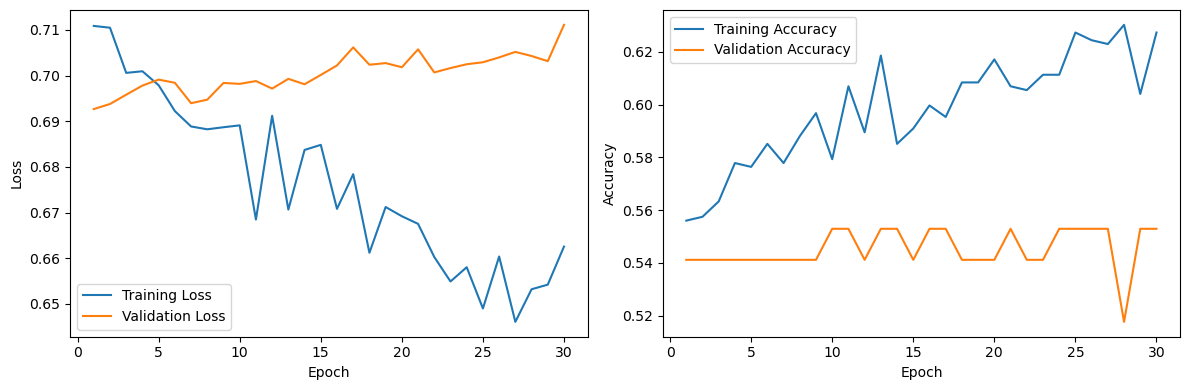

In [6]:
# Lists to store values for plotting
from cgi import test


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader):
        # convert labels to float because criterion requires float type labels
        labels = labels.type(torch.FloatTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs > 0.5
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_labels = val_labels.type(torch.FloatTensor)
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs > 0.5
            val_correct += (val_predicted == val_labels).sum().item()
            val_samples += val_labels.size(0)

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_labels = test_labels.type(torch.FloatTensor)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5
        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Plot learning curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


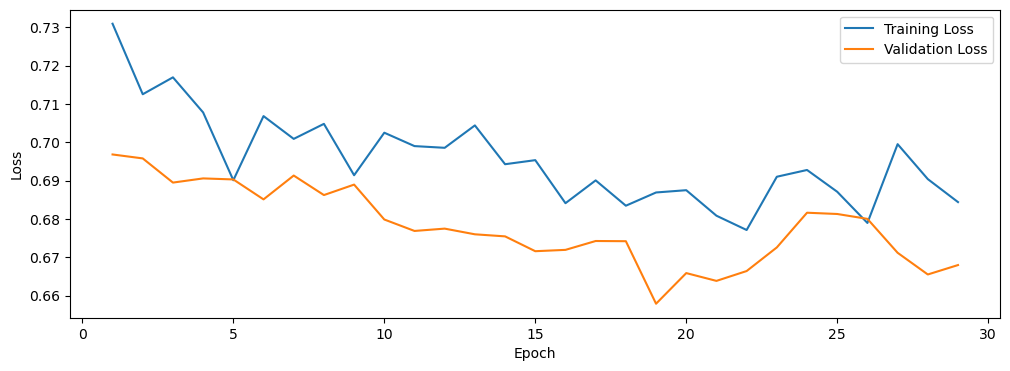

In [ ]:
xrange = range(1, num_epochs)
plt.figure(figsize=(12, 4))
plt.plot(xrange, train_losses[1:], label='Training Loss')
plt.plot(xrange, val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing - Accuracy: 0.6322


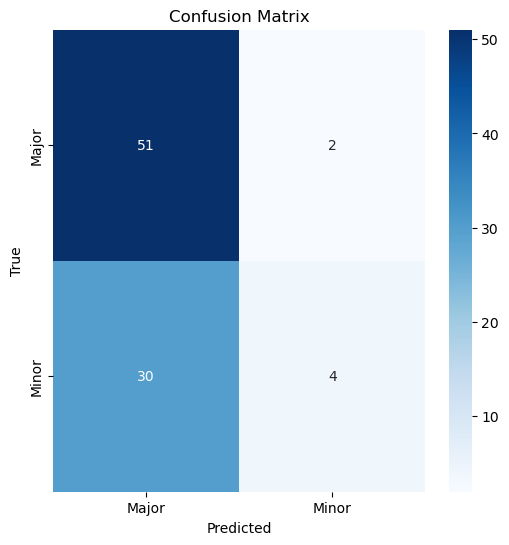

In [ ]:
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5

        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Major', 'Minor']  # Modify based on your actual class names

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()